**<center>3F2 Lab Report<center>**

Name: Louis </br>
Surname: Pender </br>
CrsId: lwp26 </br>
Apparatus #: 2

In [326]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [327]:
# Define the  physical constants for the pendulum experiment

g=9.81  # m/s^2
L=0.125 # distance from pendulum's centre of mass to pivot in m
a=0.016 # radius of pulley in m
m=0.32  # mass of pendulum in kg
M=0.7  # mass of carriage in kg
I=8e-5  # moment of inertia on motor shaft in kg m^2
km = 0.08  # torque motor constant in Nm/A
ka = -0.50 # amplifier constant in A/V

gamma =  M/m + I/(m*np.power(a,2))

#scale factors to get physical units metres radians and seconds.
#in the crane/down position
# [x xdot Ltheta Lthetadot]=[CP CV PP PV]*Sc where,
Sc=np.diag([-1/12.5, -1/2.23, L/3.18, L/0.64])

# in the inverted position
# [x xdot Lphi Lphidot]=[CP CV PP PV]*Sp where,
Sp=np.diag([-1/12.5, -1/2.23, L/3.18, -L/0.64])

#controller amplifier gains on each measurement
opamp_c = np.diag([-20,-30, 20, -10]) # for crane controller
opamp_p = np.diag([10,20,30,-20]) # for inverted pendulum controller

#maximum torque from the motor in Nm
Tmax=0.4

# squares of the natural frequencies
om12=g/L 
om02=om12*(1+1/gamma)

#linearized crane  model

Ac=np.array([[0, 1, 0, 0,], [0, 0, om12-om02, 0], [0, 0, 0, 1], [0, 0, -om02, 0]])
Cc=-(ka*km/(m*a*gamma))*np.linalg.solve(Sc,opamp_c)
B=np.array([[0],[1],[0],[1]])

#linearized inverted pendulum model
Ap=np.array([[0, 1, 0, 0], [0, 0, om02-om12, 0], [0, 0, 0, 1], [0, 0, om02, 0]])
Cp=-(ka*km/(m*a*gamma))*np.linalg.solve(Sp,opamp_p)

# Sampling period 
h=0.0025 #sampling period
h_sim=0.002 #simulation step size

Helper functions are defined here (you should not have to change these). Click to reveal and then click the vertical bar to rehide.

In [328]:
# Define helper functions

def solver_crane(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1
    
  def next_state_crane(x):
    theta = x[2]/L
    sinth = np.sin(theta)
    costh = np.cos(theta)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a - m*g*sinth*costh - m/L*sinth*x[3]**2)< Fstatic):
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(-g*sinth)
        sinth1 = np.sin(newx[2]/L)
        costh1 = np.cos(newx[2]/L)
        newx[3] = x[3] -h_sim*g*(sinth+sinth1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-costh],[-costh,1]]),np.array([-sinth/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinth1 = np.sin(newx[2]/L)
         costh1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-costh1],[-costh1,1]]),np.array([-sinth1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*P@ opamp_c@ np.linalg.solve(Sc,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_crane(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim
# Define helper functions

def solver_pendulum(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1

  def next_state_pendulum(x):
    phi = x[2]/L
    sinphi = np.sin(phi)
    cosphi = np.cos(phi)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a + m*g*sinphi*cosphi - m/L*sinphi*newx[3]**2)< Fstatic): #x[3]
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(g*sinphi)
        sinphi1 = np.sin(newx[2]/L)
        cosphi1 = np.cos(newx[2]/L)
        newx[3] = x[3] +h_sim*g*(sinphi+sinphi1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-cosphi],[cosphi,-1]]),np.array([-sinphi/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinphi1 = np.sin(newx[2]/L)
         cosphi1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-cosphi1],[cosphi1,-1]]),np.array([-sinphi1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*P@ opamp_p@ np.linalg.solve(Sp,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_pendulum(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim

def loadlogdata(n,ScaleF):
  folder = "data/"

  if n> 9:
    filename = folder + 'Plot 0' + str(n) + '.csv'
  else:
    filename = folder + 'Plot 00' + str(n)+ '.csv'

  LoadedDataCSV = np.genfromtxt(filename,delimiter=',',skip_header=16)
  # this seems to be sufficient if the offset for the header is always the same
  #print(LoadedDataCSV)
  #LoadedDataCSV = np.delete(LoadedDataCSV,-1,axis=1)
  #print(LoadedDataCSV)
  DataOfInterestCSV = np.array(LoadedDataCSV[:,[2,3,4,5,1]])
  # we now need to swap data so to place it in the following order
  # t CP CV PP PV CD
  # from an orginal order of: 
  # t CD CP CV PP PV
  logdataCSV = DataOfInterestCSV*20/4095-10
  logdataCSV[:,[1,2,3]] = -logdataCSV[:,[1,2,3]]
  xdata=np.concatenate([logdataCSV[:,0:4]@ScaleF, logdataCSV[:,-1:]*ScaleF[0,0]], axis=1)
  ###  
  xdem = xdata[:,-1]
  endtime=LoadedDataCSV[-1,0]
  t = np.linspace(0,endtime,xdata.shape[0])

  return xdata, xdem, t
 
def plot_function_crane(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Crane position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")
  plt.grid()

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")
  plt.grid()

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\Theta$[m]")
  plt.grid()

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\omega$[m/s]")
  plt.grid()

  plt.xlabel("time [s]")

def plot_function_pendulum(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Pendulum position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")
  plt.grid()

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")
  plt.grid()

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\Theta$[m]")
  plt.grid()

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$\omega$[m/s]")
  plt.grid()

  plt.xlabel("time [s]")

# 3) Crane mode

## 3.1) Friction measurement
Measure the dynamic and static friction

In [329]:
F = 3
Fstatic = 2.4

Notes:
Run 1. Critical response for carriage
Run 3. Critical carriage parameters with p3 = 0.05 p4 = 0
Run 4. Critical carriage parameters with p3 = 0.2 p4 = 0
Run 5. Critical carriage parameters with p3 = 0.3 p4 = 0
Run 6. Critical carriage parameters with p3 = 0.05 p4 = 0.05
Run 7. Critical carriage parameters with p3 = 0.2 p4 = 0.05
Run 8. Critical carriage parameters with p3 = 0.3 p4 = 0.05
Run 9. Critical carriage parameters with p3 = 0.05 p4 = 0.2
Run 10. Critical carriage parameters with p3 = 0.1 p4 = 0.2
Run 11. Critical carriage parameters with p3 = 0.2 p4 = 0.2

Run 12. Critical carriage parameters with p3 = 0.05 p4 = 0.1
Run 13. Critical carriage parameters with p3 = 0.1 p4 = 0.1
Run 14. Critical carriage parameters with p3 = 0.2 p4 = 0.1

Best so far I would say has been run 13

RUN 15 BEST RUN for p3 and p4 poles

## 3.3) Synthesis of the $p_3$ and $p_4$ controllers


In [330]:
P = np.array([[0.35,0.15,0.1,0.1]]); # for run 15
print(np.linalg.eig(Ac-B@P@Cc)[0]) # Note that the [0] is there to ignore the second output of eig

[-3.89861823+18.69316043j -3.89861823-18.69316043j
 -2.16928301 +6.46486529j -2.16928301 -6.46486529j]


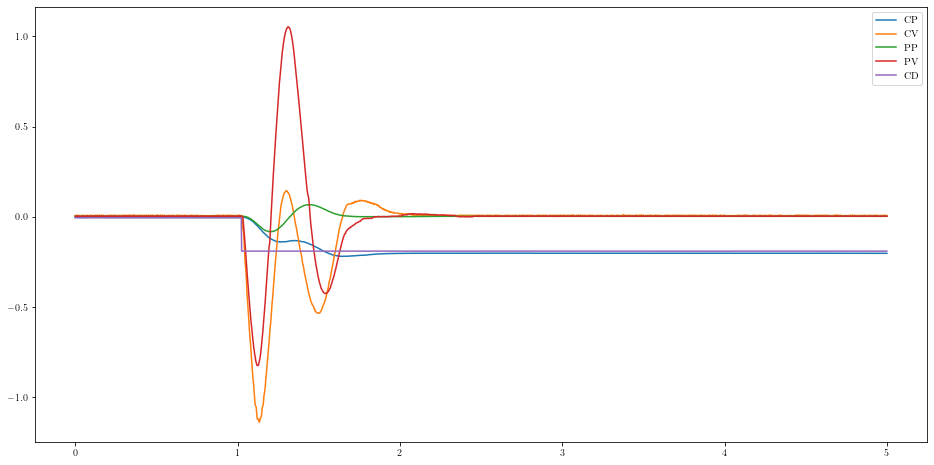

In [331]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(15,Sc)
# in the previous line xdem is the external input into the system.
plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

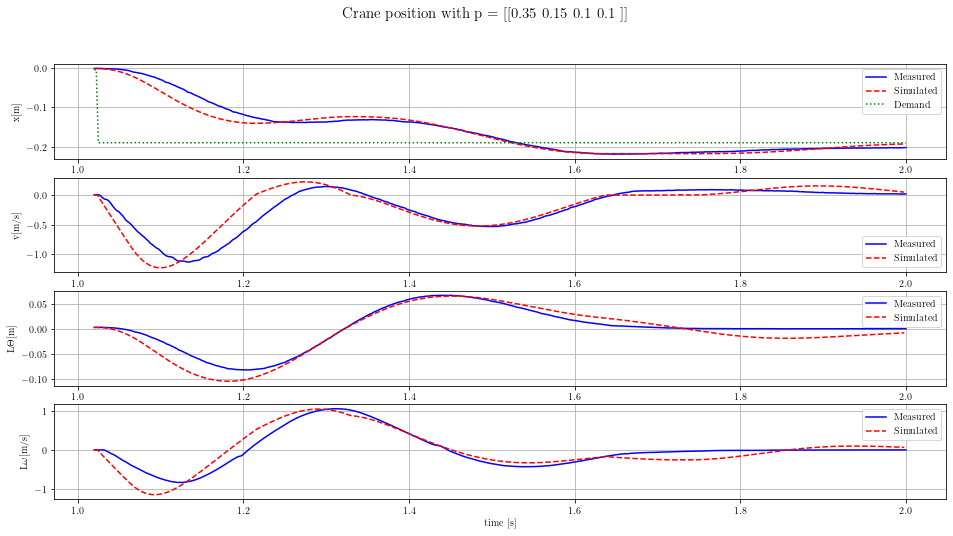

In [332]:
t0 = 1.02; tf = 2 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment on the transient response and pole position

Pole locations:
$[-3.89861823 \pm 18.69316043j, -2.16928301 \pm 6.46486529j]$
These indicate a highly damped system with frequencies of 18.7 and 6.5 rad/s.



The large imaginary terms show a high frequency, but smaller real terms suggest this is highly damped.
The other two poles show a lower frequency response while still being highly damped

## 3.4) Pole-placement

### 3.4a)  
Use example 1 of section A.5 together with the scale factors of section A.7 to place all the closed-loop poles at $−\omega_1 = −\sqrt 78.5$. Record your calculated values of $p_1–p_4$

In [333]:
omega1_34 = np.sqrt(78.5)
omega0_34 = np.sqrt(103.3)
k1_34 = omega1_34 ** 2
k2_34 = 4 * omega1_34
k3_34 = 5 * omega1_34 ** 2 - omega0_34 ** 2
k4_34 = 0

p1_34 = k1_34 / 617
p2_34 = k2_34 / 165
p3_34 = k3_34 / 1256
p4_34 = k4_34 / -126

print(p1_34, p2_34, p3_34, p4_34)
parr = np.array([p1_34, p2_34, p3_34, p4_34])
print(parr.round(2))

0.12722852512155589 0.21478842602023454 0.23025477707006364 -0.0
[ 0.13  0.21  0.23 -0.  ]


In [334]:
P = np.array([parr.round(2)])
print("P:", P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[ 0.13  0.21  0.23 -0.  ]]
[-12.45360996+6.46216554j -12.45360996-6.46216554j
  -4.89083448+2.84116008j  -4.89083448-2.84116008j]


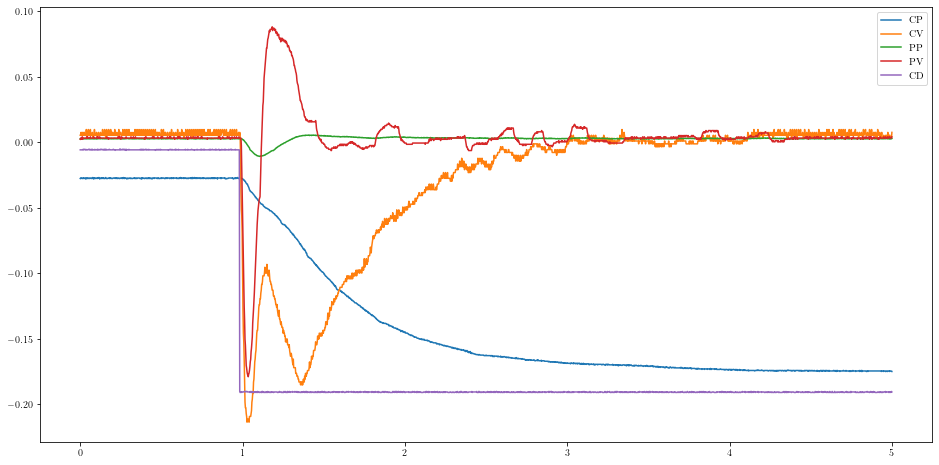

In [335]:
############################## LOAD DATA #######################################
xdata, xdem, tdata =loadlogdata(16,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

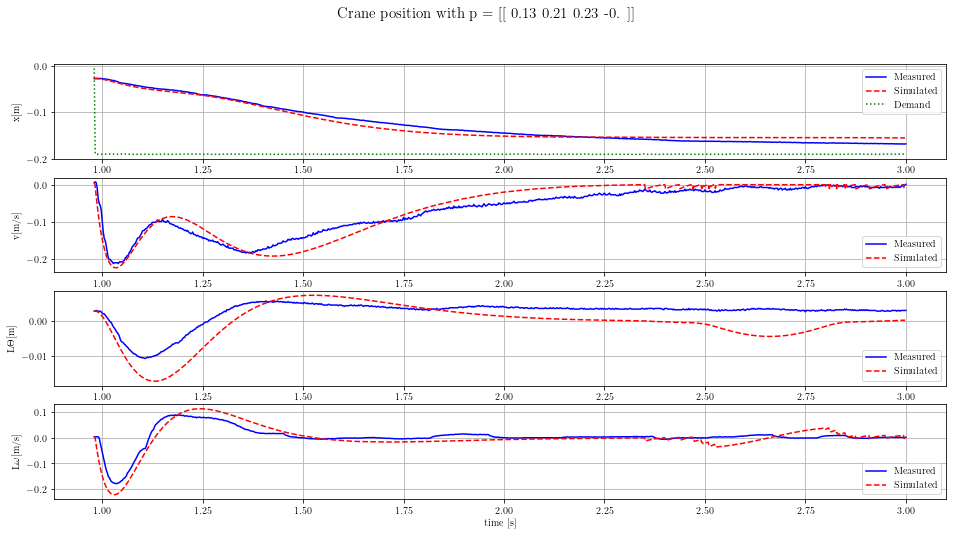

In [336]:
t0 = 0.98; tf = 3 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)
plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)


# Comment on the consistency with the target pole position

There is quite a difference between measured and simulated.
The measured response has a higher frequency than the simulated.



### 3.4b)  
Now increase the speed of response by placing the closed-loop poles at $-\alpha,-\beta,-\omega\pm j\omega$ for suitable values of $\alpha, \beta$ and $\omega$. Record your choice (of $\alpha, \beta$ and $\omega$) and the corresponding potentiometer settings. Log the step response and comment. *[It is not expected that you will choose the same values as any other student!]*.

In [337]:
alpha = 10; beta = 10; omega = 10
k = np.empty(4)
k[0]=2*omega**2*alpha*beta/om12
k[1]=(2*omega**2*(alpha+beta)+2*omega*alpha*beta)/om12
k[2]=2*omega**2+2*omega*(alpha+beta)+alpha*beta-om02-k[0]
k[3]=2*omega+alpha+beta-k[1] 
P=np.array([k/np.diag(Cc)])
print("alpha=", alpha, "beta=", beta, "omega =",omega)
print("P= ",P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 



alpha= 10 beta= 10 omega = 10
P=  [[0.41284404 0.46282964 0.27212883 0.28834576]]
[-10.+1.00000000e+01j -10.-1.00000000e+01j -10.+1.08564988e-06j
 -10.-1.08564988e-06j]


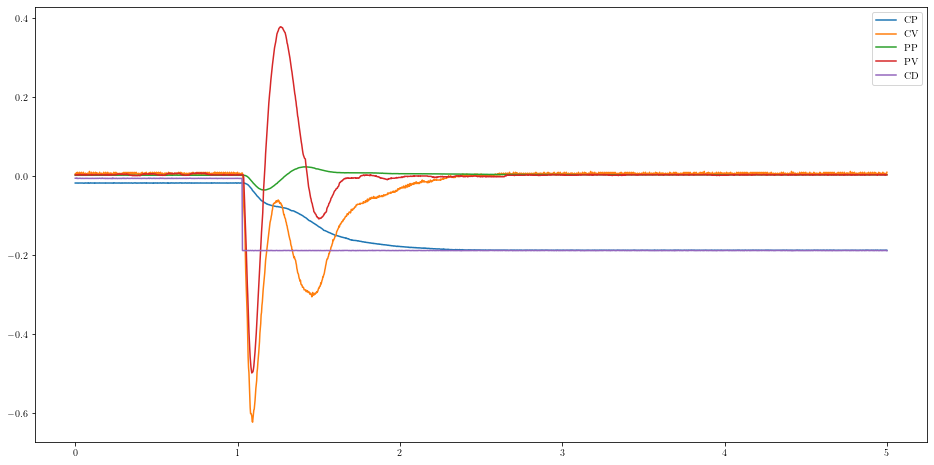

In [338]:
############################## LOAD DATA #######################################
xdata, xdem, tdata =loadlogdata(19,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

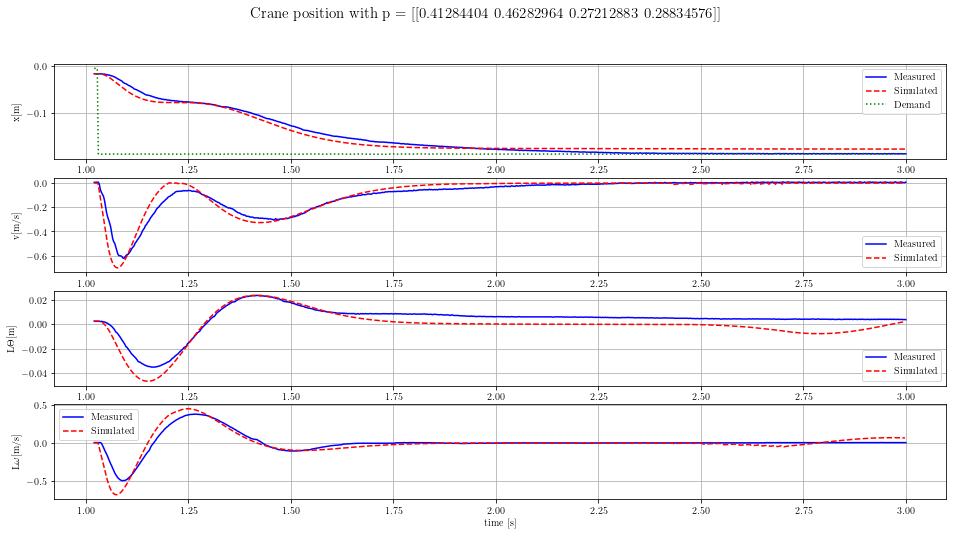

In [339]:
t0 = 1.02; tf = 3 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)


# Comment here on the response

The calculated values of P are $[0.41284404 0.46282964 0.27212883 0.28834576]$ </br>
The poles are $[-10.0 \pm 10.0j, -10.0\pm 1.08564988\times 10^{-6}j ]$ which is very close to the design point of a repeated pole at $-10$, and poles at -$10\pm 10j$

From measuring the response, the frequency of the carriage velocity was found to be 15.71 rad/s, which is close to the desired 10 rad/s.



The response matches that of the simulation better than before.


## 3.5) Variation of $p_2$
With the design 3.4(b) vary $p_2$ until instability just occurs. Log the step response just prior to the onset of oscillations, and record the value of $p_2$. Use the linear model in appendix A to predict the gain $k_2$ at which oscillation will occur, and predict the resonant frequency $\hat \omega$ see section A.5). Compare these with your experimental results (note: $k_2$ = 165 $p_2$ — see A.7(a))

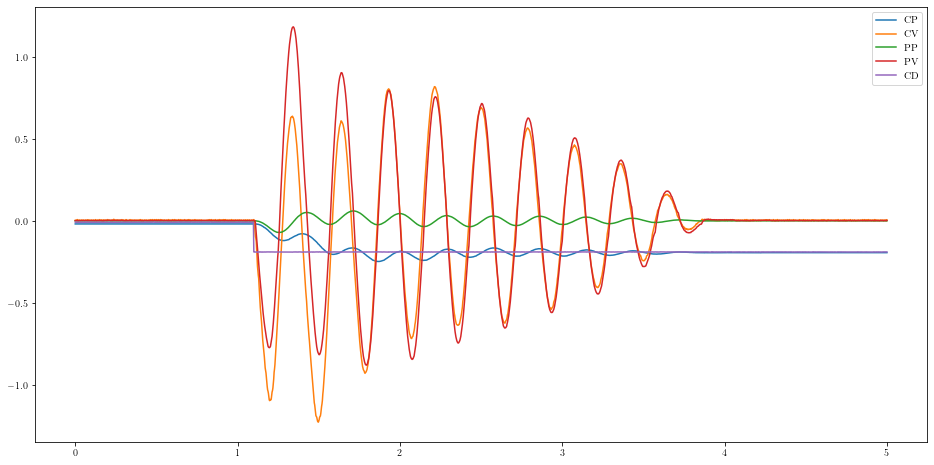

In [340]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(21,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

In [341]:
P = np.array([[0.41,0.19,0.27,0.29]])
print("P:", P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 


P: [[0.41 0.19 0.27 0.29]]
[ 4.57476482+26.11156105j  4.57476482-26.11156105j
 -1.93649322 +4.95114934j -1.93649322 -4.95114934j]


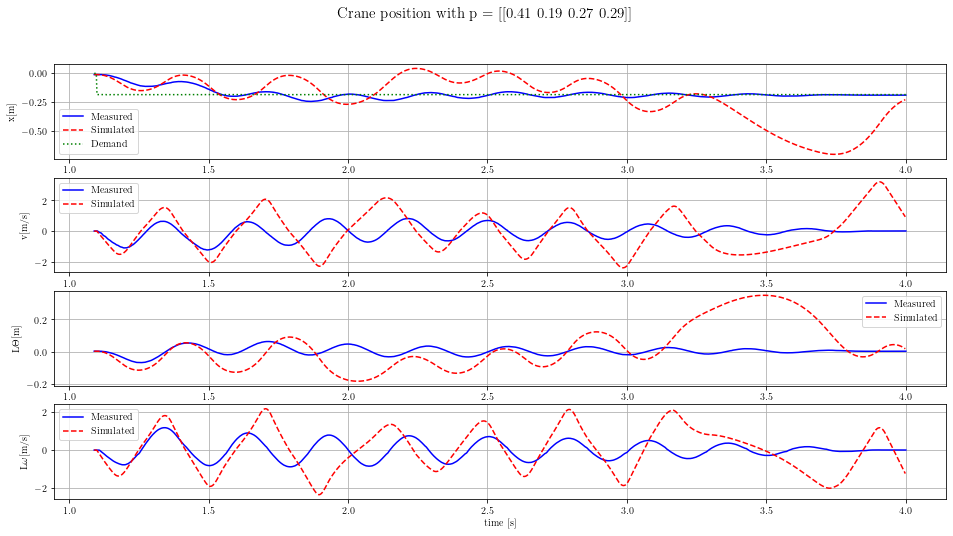

In [342]:
t0 = 1.09; tf = 4 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)
plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)

In [343]:
k1 = P[0,0] * 617
k3 = P[0,2] * 1256
k4 = P[0,3] * -126

print(k4)

a = (k3 + omega0_34 ** 2 - omega1_34 ** 2)
b = k4 * (k3 + omega0_34 ** 2 - k1)
c = - k1*k4**2

k2_1 = (-b + np.sqrt(b**2 - 4*a*c))/ (2*a)
k2_2 = (-b - np.sqrt(b**2 - 4*a*c))/ (2*a)

omega_predicted = np.sqrt(k2_1 / (k2_1 + k4)) * omega1_34
predicted_frequency = omega_predicted / (2 * np.pi)
predicted_gain = k2_1
print(k2_1, k2_2)
print("Predicted gain k2: ", predicted_gain)
print("Predicted frequency", predicted_frequency, "Hz")

print()
measured_frequency = 7/2.03
measured_gain = 165 * 0.19
delta_gain = 0.46*165 - measured_gain
print("Measured Gain", measured_gain)
print("Measured frequency", measured_frequency, "Hz")
print("Delta gain", delta_gain)

-36.54
41.426084064823016 -22.404038010745197
Predicted gain k2:  41.426084064823016
Predicted frequency 4.105928985604413 Hz

Measured Gain 31.35
Measured frequency 3.4482758620689657 Hz
Delta gain 44.550000000000004


 # Comment and discuss here section 3.5)
$[ 4.57476482 \pm 26.11156105j , -1.93649322 \pm 4.95114934j]$

Predicted gain k2:  41.426084064823016 </br>
Predicted frequency 4.105928985604413 Hz

The value of $p_2$ was reduced from 0.46 to 0.19 where the onset of oscillations was observed</br>
Measured Gain 31.35 </br>
Measured frequency 3.4482758620689657 Hz
The amplitude of velocity of the carriage drops to half of the maximum value after 4 cycles, which gives the damping ratio as $\zeta \approx 0.03$
This means we can predict the pole to be at $-0.65 \pm 21.66j$

Measurements indicate that the gain $k_2$ for unstability is smaller than expected. </br>
This results in a frequency response at lower frequency than expected.

From theory covered in A6 of the appendix, the onset of instability is due to friction in the limit cycles which is not considered in linear theory.
This shows that for large oscillations the damping due to friction is smaller than predicted by the linear model which should cause instability at a higher gain than expected. </br>
However, the measured gain was lower than expected for the onset of instability ???.


# 4) Pendulum mode

## 4.2) No carriage feedback
Set $p_1 = p_2 = 0$ and $p_3$ and $p_4$ to stabilize the pendulum dynamics, say $p_3 = 0.500$ and $p_4 = 0.110$.  Now hold the pendulum upright and press RESET.  Manually note the force, on the pendulum, required to move the carriage - TAKE DUE CARE. Let go of the pendulum and explain the subsequent behaviour.

In [344]:
P = np.array([[0.0, 0.0, 0.5, 0.11]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.   0.   0.5  0.11]]
[  0.         +0.j           0.         +0.j
 -13.90617284+25.40781422j -13.90617284-25.40781422j]


 # Comment and disucss here section 4.2)

The pendulum position drifts away from the zero position with increasing carriage velocity showing unstability.
This is due to the small pendulum angle.


## 4.3) Pole placement
Using example 2 in section A.5 and the data in section A.7 calculate $p_i$ to place the closed-loop poles at $-\omega_1=-\sqrt{78.5}$, and record your calculated values. Log the response.

In [345]:
omega0_43 = np.sqrt(103.3)
omega1_43 = np.sqrt(78.5)

k1_43 = - omega1_43 ** 2
k2_43 = -4 * omega1_43
k3_43 = omega0_43 ** 2 + 7 * omega1_43 ** 2
k4_43 = 8 * omega1_43

p1_43 = k1_43 / -309
p2_43 = k2_43 / -110
p3_43 = k3_43 / 1884
p4_43 = k4_43 / 253

P = np.array([[p1_43, p2_43, p3_43, p4_43]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25404531 0.32218264 0.34649682 0.28015882]]
[-10.62609236+2.74532358j -10.62609236-2.74532358j
  -7.05158309+1.16740753j  -7.05158309-1.16740753j]


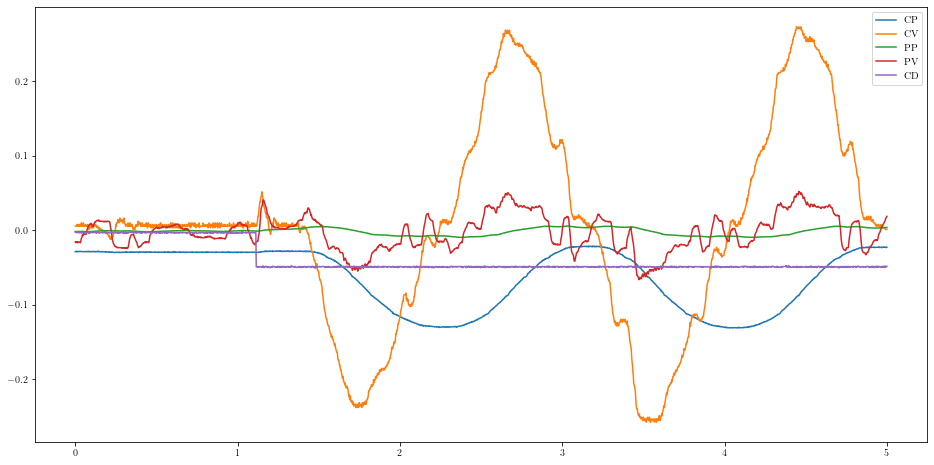

In [346]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(28,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

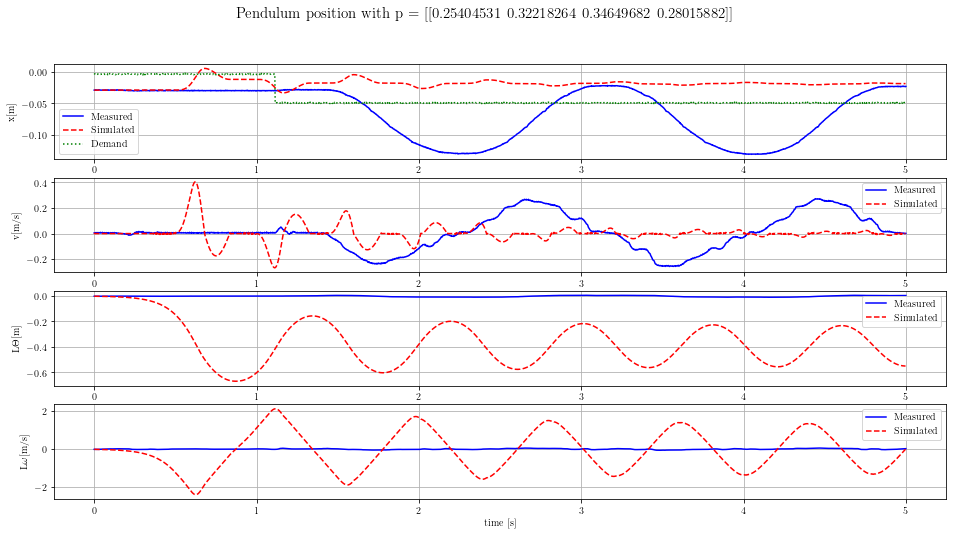

In [347]:
t0 = 0.0; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)


## 4.4) Limit Cycles
Set the potentiometers to $p_1 = 0.23 \ \ p_2 = 0.50 \ \ p_3 = 0.63 \ \ p_4 = 0.40$ which should give a reasonably stable response. Now reduce $p_2$ until large oscillations occur (i.e. the carriage nearly hits the end stops). Record your value of $p_2$, and log the response.  Now increase $p_2$ until the system is almost unstable. Record your value of $p_2$, and log the response to a small step.

In [348]:
P = np.array([[0.25, 0.30, 0.63, 0.40]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25 0.3  0.63 0.4 ]]
[-48.32061766+0.j         -17.23756591+0.j
  -1.27029093+2.37834982j  -1.27029093-2.37834982j]


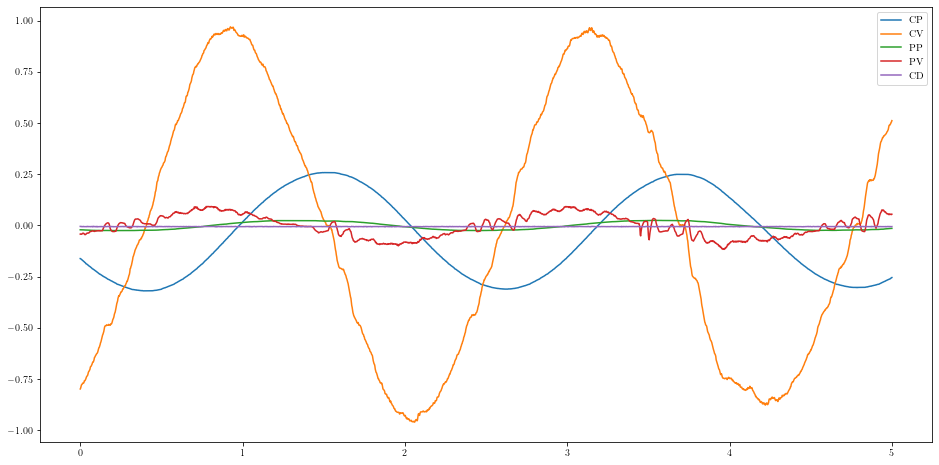

In [349]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(26,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

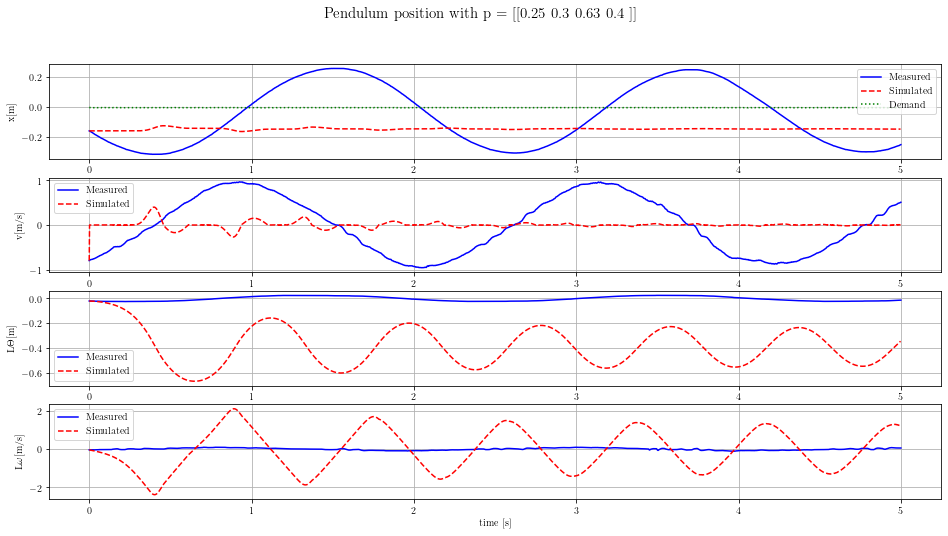

In [350]:
t0 = 0; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment and discuss here section 4.4)

Value of $p_2$ for large oscillations: <br>

The valye of $p_2 = 0.3$ was found for large oscillations.
This can be seen in the poles $-1.27029093 \pm 2.37834982j$
These have a small imaginary component and so have a lower frequency, as observed.
The value of damping is also small which is given by the real part.


Now vary $p_2$

In [351]:
P = np.array([[0.25, 0.78, 0.63, 0.40]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25 0.78 0.63 0.4 ]]
[-4.07147154+30.42971361j -4.07147154-30.42971361j
 -1.06521658 +0.j         -6.0313465  +0.j        ]


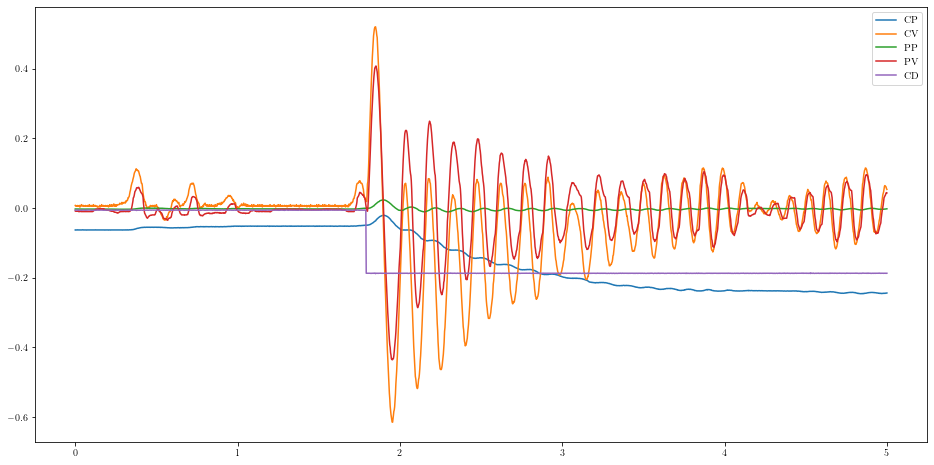

In [352]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(27,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

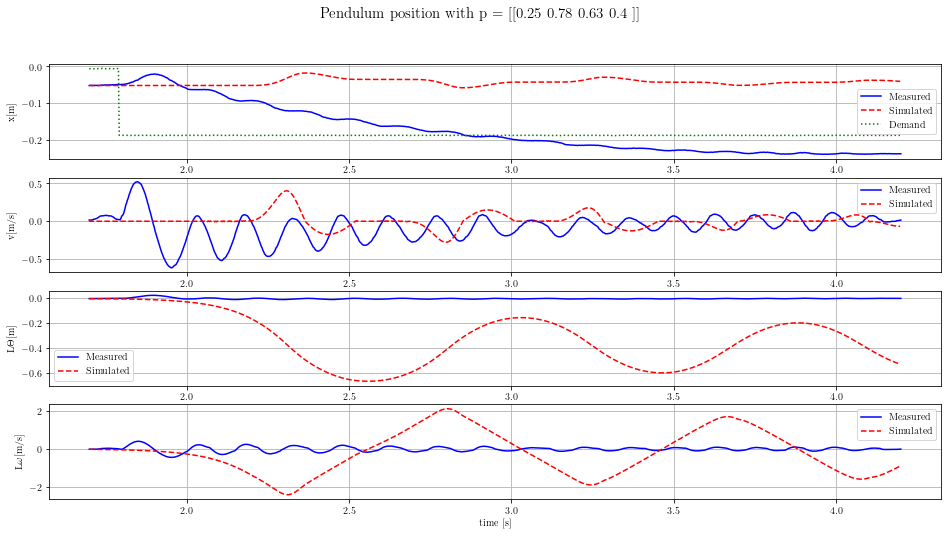

In [353]:
t0 = 1.7; tf = 4.2 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment and discuss here section 4.4) after changing $p_2$

Value of $p_2$ for at the onset of instability: 0.78
The carriage velocity amplitude halves after 7 cycles giving a damping ratio of $\zeta \approx 0.016$
The frequency of carriage velocity is calculated to be about 44 rad/s
This gives calculated poles of $-0.704 \pm 44j$

The corresponding poles of the system are $-4.07147154 \pm 30.42971361j$
This shows that the damping is higher than expected 

## Describe and explain the beahviour when $p_3=p_4=0$



## 4.5) No pendulum feedback
If the design of 4.3) is implemented except with $p_3 = p_4 = 0$ what would happen, and why?

In [354]:
P = np.array([[0.25, 0.32, 0, 0]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25 0.32 0.   0.  ]]
[37.96301272  8.51904027 -2.03316228 -9.20938453]


# Comment and discuss here section 4.5

We observe the unstable pole: 37.96301272
Which causes the carriage to move away from its set position.
This happens because when the angular velocity of the pendulum is in the direction away from the center then the carriage must stablilise it by moving away from the center.
Similarly when the angular velocity is in a direction towards the center, the carriage moves towards the center.



# <center> Feedback to the student <center>

## Content

### Completeness, quantity of content: Very good | Good | Needs improvement
Has the report covered all aspects of the lab? Has the analysis been carried out thoroughly?

### Correctness, quality of content: Very good | Good | Needs improvement
Is the data correct? Is the analysis of the data correct? Are the conclusions correct?

### Depth of understanding, quality of discussion: Very good | Good | Needs improvement
Does the report show a good technical understanding? Have all the relevant conclusions been drawn?

### Comments

...

## Presentation

### Attention to detail, typesetting and typographical errors: Very good | Good | Needs improvement
Is the report free of typographical errors? Are the figures/tables/references presented professionally?

### Comments

...

# Raw report Mark:
The weighting of comments is not intended to be equal, and the relative importance of criteria may vary between modules. A good report  should  attract 4 marks.

# Penalty for lateness: 
1 mark / week or part week.Please refer to the online information regarding our extension policy.

Marker: <br>
Date: <br>